# **Upload sample_data to drive**





In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

shutil.move('sampled_data.csv', '/content/drive/MyDrive/111/sampled_data.csv')

'/content/drive/MyDrive/111/sampled_data.csv'

# **Data Preparation --- download images and make text features**

Since downloading images and generating embeddings is time-consuming, our team downloads the images and precomputes the embeddings once, then saves them for future training runs. Therefore, this part of the code is intended to be executed only by users running the script for the first time.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/111/sampled_data.csv")

In [ ]:
df.head(10)

main_category                                              title  \
0   Amazon Home  3 Pieces Purple and Gold Tablecloth Arabian Ni...   
1          Baby  Baby Einstein Octopus Lovey Soothing Musical P...   
2  Toys & Games  HONGDDY 2 in 1 Matching Puzzle Games, Crabzzle...   
3  Toys & Games          Battles of Westeros: House Baratheon Army   
4  Toys & Games  petich Sonic Plush Sonic The 2 The Movie Plush...   
5  Toys & Games  20pcs Mother's Day Heart Balloons 18 Inch Feli...   
6   Amazon Home  Koehler 10016048 8.25 Inch Gray Get Well Soon ...   
7  Toys & Games  Luck Lab Leather Tarot Card Case/Holder - Blac...   
8  Toys & Games  Karenhi 6 Pcs 2023 Graduation Bear Stuffed Ani...   
9    Automotive  American Racing AR92167017440 Ar921 Trigger 6X...   

   average_rating  rating_number  \
0             4.4             89   
1             4.7          13511   
2             4.4              9   
3             4.5             23   
4             4.4             58   
5             3.9              9   
6             5.0              1   
7             3.4             14   
8             4.4              7   
9             4.1              6   

                                            features  \
0  ['Easy to Use: purple and gold table decoratio...   
1  ['Opus’s Look Sea Listen is a soothing, musica...   
2                                                 []   
3  ['The first Great House expansion for Battles ...   
4  ['【Fun Design】A plush toy that can make childr...   
5  ['❤ Material: Aluminum foil. Pattern: Random S...   
6  ['Polyester' 'Importado' 'Perfect gift for tho...   
7  ['Single deck travel size (4.2 x 2.5 inches) t...   
8  ['Package Content: you will receive 6 pieces o...   
9  ['Leading Manufacturer Of High-Quality Product...   

                                         description  price  \
0                                                 []  11.99   
1  ['The Baby Einstein Ocean Explorers Opus’s Loo...  15.19   
2                                                 []    NaN   
3  ['From the Manufacturer'\n "For the first time...  69.95   
4                                                 []  32.99   
5  ["Are you preparing for your Mother's Day part...  12.99   
6  ['The road to recovery begins with cuddles and...    NaN   
7  ['★★★Introducing the Luck Lab premium Travel S...    NaN   
8  ['The package contains 6 Pcs Graduation Stuffe...  15.99   
9  ['American Racing AR92167017440 Ar921 Trigger ...    NaN   

                                              images  \
0  {'hi_res': array(['https://m.media-amazon.com/...   
1  {'hi_res': array(['https://m.media-amazon.com/...   
2  {'hi_res': array(['https://m.media-amazon.com/...   
3  {'hi_res': array(['https://m.media-amazon.com/...   
4  {'hi_res': array(['https://m.media-amazon.com/...   
5  {'hi_res': array(['https://m.media-amazon.com/...   
6  {'hi_res': array(['https://m.media-amazon.com/...   
7  {'hi_res': array(['https://m.media-amazon.com/...   
8  {'hi_res': array(['https://m.media-amazon.com/...   
9  {'hi_res': array(['https://m.media-amazon.com/...   

                                              videos                 store  \
0  {'title': array(['Good quality but smaller tha...                 Tatuo   
1  {'title': array(['Literally my baby is mesmeri...         Baby Einstein   
2  {'title': array(['Fat Brain Toys Bugzzle',\n  ...               HONGDDY   
3  {'title': array(['A Song of Ice & Fire Golden ...  Fantasy Flight Games   
4  {'title': array(['The Movie Tails & Sonic the ...                petich   
5  {'title': array([], dtype=object), 'url': arra...                 JANOU   
6  {'title': array([], dtype=object), 'url': arra...               Koehler   
7  {'title': array([], dtype=object), 'url': arra...              Luck Lab   
8  {'title': array(['4 Inch Graduation Stuffed Be...               Karenhi   
9  {'title': array([], dtype=object), 'url': arra...                   AMT   

                                          categ

In [ ]:
import os
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

save_folder = "/content/drive/MyDrive/downloaded_images"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    print(f"created folder: {save_folder}")
else:
    print(f"folder existed: {save_folder}")

# image download function
def download_image(args):
    index, url = args

    # for check
    if pd.isna(url) or url == "":
        return f"Index {index}: URL N.A."

    try:
        # setup timeout
        response = requests.get(url, stream=True, timeout=10)

        if response.status_code == 200:

            ext = os.path.splitext(url)[1]
            if not ext or len(ext) > 5:
                ext = ".jpg"

            filename = f"{index}{ext}"
            file_path = os.path.join(save_folder, filename)

            with open(file_path, 'wb') as f:
                f.write(response.content)
            return None
        else:
            return f"Index {index}: HTTP error {response.status_code}"

    except Exception as e:
        return f"Index {index}: error download - {str(e)}"

# 3. Prepare data
# Pack index and URL into a list of download tasks
tasks = list(zip(df.index, df['primary_image_url']))

print(f"Preparing to download {len(tasks)} images...")

# 4. Start multithreaded downloading (max_workers=10 means downloading 10 images in parallel)
# tqdm is used to show a progress bar
results = []
with ThreadPoolExecutor(max_workers=10) as executor:
    # list(tqdm(...)) forces execution and displays progress
    results = list(tqdm(executor.map(download_image, tasks), total=len(tasks), unit="img"))

# 5. (Optional) Print failed download records
errors = [res for res in results if res is not None]
if errors:
    print(f"\nDownload completed, but {len(errors)} errors occurred:")
    # Print only the first 10 errors to avoid overwhelming output
    for err in errors[:10]:
        print(err)
    if len(errors) > 10:
        print("...")
else:
    print("\nAll images downloaded successfully!")

已创建文件夹: /content/drive/MyDrive/downloaded_images
准备下载 20000 张图片...


100%|██████████| 20000/20000 [08:14<00:00, 40.44img/s]


下载完成，但有 1 个错误:
Index 17929: 下载出错 - ('Connection broken: IncompleteRead(32768 bytes read, 219682 more expected)', IncompleteRead(32768 bytes read, 219682 more expected))


In [ ]:
# 1. Install dependencies (Colab)
!pip install transformers torch pandas pillow tqdm matplotlib

import os
import torch
import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel

# ================= Path configuration =================
csv_path = "/content/drive/MyDrive/111/sampled_data.csv"
image_folder = "/content/drive/MyDrive/downloaded_images"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ================= 2. Data cleaning (updated text-merging logic) =================
df = pd.read_csv(csv_path)
valid_data = []

print("Cleaning dataset and merging text fields...")

# Helper function: safely convert a value to string (avoid NaN issues)
def clean_str(val):
    if pd.isna(val):
        return ""
    return str(val).strip()

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_name = f"{idx}.jpg"
    img_path = os.path.join(image_folder, img_name)

    # --- Main update: merge ALL textual fields into one combined string ---
    title = clean_str(row.get('title'))
    features = clean_str(row.get('features'))
    desc = clean_str(row.get('description'))
    categories = clean_str(row.get('categories'))
    details = clean_str(row.get('details'))

    # Concatenate text fields (space-separated)
    combined_text = f"{title} {features} {desc} {categories} {details}".strip()

    # Keep only entries where the image exists AND combined text is non-empty
    if os.path.exists(img_path) and combined_text != "":
        valid_data.append({
            "original_index": idx,
            "image_path": img_path,
            # Remove the previous [:77] truncation — let tokenizer handle it
            "text": combined_text
        })
    # --- End of modifications ---

proc_df = pd.DataFrame(valid_data).reset_index(drop=True)
print(f"\nValid samples: {len(proc_df)} (original dataset size: {len(df)})")

# ================= 3. Extract features using pretrained CLIP (skip broken images) =================
print("\nLoading CLIP model for feature extraction...")
model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

all_img_features = []
all_txt_features = []
kept_rows = []      # Record successfully processed rows
batch_size = 64

print("Generating embeddings (skipping unreadable or invalid images)...")
skipped_count = 0
bad_files = []

with torch.no_grad():
    for i in tqdm(range(0, len(proc_df), batch_size)):
        batch = proc_df.iloc[i : i + batch_size]

        images = []
        texts = []
        local_kept = []

        for _, row in batch.iterrows():
            p = row['image_path']

            # 1. Check file size (filter corrupted dummy images)
            try:
                if os.path.getsize(p) < 200:
                    skipped_count += 1
                    bad_files.append((p, "too_small"))
                    continue
            except Exception:
                pass

            # 2. Try to open image
            try:
                img = Image.open(p)
                img = img.convert("RGB")
                images.append(img)
                texts.append(row['text'])   # use merged text
                local_kept.append(row.to_dict())
            except (UnidentifiedImageError, OSError, Exception) as e:
                skipped_count += 1
                bad_files.append((p, str(e)))

        if len(images) == 0:
            continue

        # 3. Forward pass through CLIP
        # truncation=True ensures text is truncated to 77 tokens automatically
        inputs = processor(
            text=texts,
            images=images,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = clip_model(**inputs)

        all_img_features.append(outputs.image_embeds.cpu())
        all_txt_features.append(outputs.text_embeds.cpu())
        kept_rows.extend(local_kept)

# ================= 4. Process and save results =================
if len(all_img_features) > 0:
    raw_img_embeds = torch.cat(all_img_features)
    raw_txt_embeds = torch.cat(all_txt_features)

    # Update DataFrame to match successfully processed rows
    kept_df = pd.DataFrame(kept_rows).reset_index(drop=True)

    print(f"\nFeature extraction completed!")
    print(f"Total embeddings: {raw_img_embeds.shape[0]}")
    print(f"Skipped corrupted samples: {skipped_count}")

    # Save all embeddings + metadata (weights_only issue fixed)
    save_path = "/content/drive/MyDrive/111/clip_features.pt"
    data_to_save = {
        "img_embeds": raw_img_embeds,
        "txt_embeds": raw_txt_embeds,
        "dataframe": kept_df
    }
    torch.save(data_to_save, save_path)
    print(f"All features and metadata saved to: {save_path}")

else:
    print("Error: No valid embeddings were extracted.")

# Show some failed file information
if len(bad_files) > 0:
    print("\nSome skipped invalid files:")
    for bf in bad_files[:5]:
        print(bf)

正在使用设备: cuda
正在清洗数据，合并文本信息...


100%|██████████| 20000/20000 [00:07<00:00, 2722.43it/s]



有效数据: 19999 条 (原数据: 20000 条)

加载 CLIP 模型用于特征提取...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

开始生成 Embeddings (跳过无法识别的图片)...


100%|██████████| 313/313 [19:30<00:00,  3.74s/it]



特征提取完成！
最终 Embedding 数量: 19998
跳过的损坏样本: 1
所有特征和数据已保存至: /content/drive/MyDrive/111/clip_features.pt

部分跳过的坏文件:
('/content/drive/MyDrive/downloaded_images/17929.jpg', 'too_small')


In [ ]:
import torch

# Define save path
save_path = "/content/drive/MyDrive/111/clip_features.pt"

print(f"Saving features to {save_path} ...")

# Package all necessary data into a dictionary
data_to_save = {
    "img_embeds": raw_img_embeds.cpu(),   # Ensure embeddings are moved to CPU before saving
    "txt_embeds": raw_txt_embeds.cpu(),
    "dataframe": proc_df  # Store this to keep track of image paths and original text information
}

torch.save(data_to_save, save_path)
print("Save completed! Next time you won't need to re-run CLIP extraction.")

正在保存特征到 /content/drive/MyDrive/111/clip_features.pt ...
保存成功！下次无需重新运行 CLIP。


# **Reload the dataset**

If this is your second time using the script and you have already run all the previous code successfully, you can start from this section and continue running the code to train the model.



In [2]:
import torch
import pandas as pd
import os
from google.colab import drive

# 1. Mount Google Drive (if not already mounted)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Load saved CLIP feature data
load_path = "/content/drive/MyDrive/111/clip_features.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

if os.path.exists(load_path):
    print(f"Found saved feature file, loading: {load_path}")

    # --- Important fix: use weights_only=False to allow full pickle loading ---
    loaded_data = torch.load(load_path, weights_only=False)
    # -------------------------------------------------------------------------

    # Restore saved tensors and dataframe
    raw_img_embeds = loaded_data["img_embeds"]
    raw_txt_embeds = loaded_data["txt_embeds"]
    proc_df = loaded_data["dataframe"]

    print("Load complete!")
    print(f"Image embedding shape: {raw_img_embeds.shape}")
    print(f"Text embedding shape: {raw_txt_embeds.shape}")
    print(f"Total valid samples: {len(proc_df)}")

else:
    print("Error: feature file not found. Please run the CLIP feature extraction code first.")

Found saved feature file, loading: /content/drive/MyDrive/111/clip_features.pt
Load complete!
Image embedding shape: torch.Size([19998, 512])
Text embedding shape: torch.Size([19998, 512])
Total valid samples: 19999


# **My Model**

The following part shows how we trained our matching model, called my_model, using two-tower architecture

In [3]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# ================= 1. Define dataset (with negative sampling) =================
class ContrastiveDataset(Dataset):
    def __init__(self, img_embeds, txt_embeds):
        self.img_embeds = img_embeds
        self.txt_embeds = txt_embeds
        self.num_samples = len(img_embeds)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Anchor: image embedding
        img = self.img_embeds[idx]

        # Positive sample: paired text embedding
        pos_txt = self.txt_embeds[idx]

        # Negative sample: randomly pick a mismatched text embedding
        rand_idx = np.random.randint(0, self.num_samples)
        while rand_idx == idx:
            rand_idx = np.random.randint(0, self.num_samples)
        neg_txt = self.txt_embeds[rand_idx]

        return img, pos_txt, neg_txt


# ================= 2. Define your matching model (two-tower architecture) =================
class MyCustomMatcher(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256):
        super(MyCustomMatcher, self).__init__()

        # Image tower: FC -> activation -> FC
        self.img_head = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),  # dropout to reduce overfitting
            nn.Linear(512, hidden_dim)
        )

        # Text tower: same structure as image tower
        self.txt_head = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, hidden_dim)
        )

    def forward(self, img, txt):
        # Project embeddings to a new latent space
        img_out = self.img_head(img)
        txt_out = self.txt_head(txt)

        # L2 Normalize (important for cosine similarity)
        img_out = img_out / img_out.norm(dim=-1, keepdim=True)
        txt_out = txt_out / txt_out.norm(dim=-1, keepdim=True)

        return img_out, txt_out


# ================= 3. Initialize training components =================
# Prepare DataLoader
dataset = ContrastiveDataset(raw_img_embeds, raw_txt_embeds)

# Shuffle=True is important to improve learning quality
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize model
my_model = MyCustomMatcher().to(device)

# Optimizer (learning rate can be tuned)
optimizer = optim.Adam(my_model.parameters(), lr=1e-4)

print("Custom model initialized. Ready to start training...")

Custom model initialized. Ready to start training...


Start training for 20 epochs...
Epoch 5/20 | Loss: 0.0227
Epoch 10/20 | Loss: 0.0158
Epoch 15/20 | Loss: 0.0120
Epoch 20/20 | Loss: 0.0103
Training complete! The model has been fitted to your data.


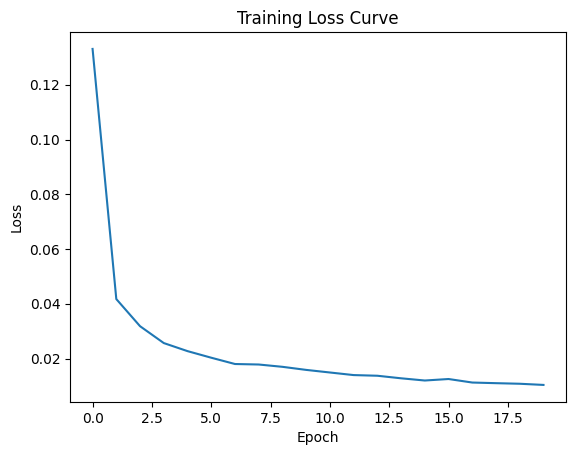

In [4]:
import numpy as np

# ================= Training Loop =================
epochs = 20     # Adjust based on dataset size; small datasets may require more epochs
margin = 0.3    # Margin hyperparameter: enforces positive pairs > negative pairs by this distance

my_model.train()  # Set model to training mode

loss_history = []

print(f"Start training for {epochs} epochs...")

for epoch in range(epochs):
    epoch_loss = 0

    for img_batch, pos_txt_batch, neg_txt_batch in train_loader:

        # Move data to device (GPU/CPU)
        img_batch = img_batch.to(device)
        pos_txt_batch = pos_txt_batch.to(device)
        neg_txt_batch = neg_txt_batch.to(device)

        optimizer.zero_grad()

        # 1. Forward pass
        # Compute projections for image and positive text
        img_proj, pos_proj = my_model(img_batch, pos_txt_batch)
        # Compute projections for negative text (reuse image branch)
        _, neg_proj = my_model(img_batch, neg_txt_batch)

        # 2. Cosine similarity (dot product because vectors are L2 normalized)
        pos_sim = (img_proj * pos_proj).sum(dim=-1)
        neg_sim = (img_proj * neg_proj).sum(dim=-1)

        # 3. Compute margin ranking loss
        # Goal: pos_sim > neg_sim + margin
        # Loss = max(0, margin - (pos_sim - neg_sim))
        loss = torch.clamp(margin - (pos_sim - neg_sim), min=0).mean()

        # 4. Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    # Print progress every few epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

print("Training complete! The model has been fitted to your data.")

# ================= Plot training curve =================
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [6]:
# save our model
final_path = "final_model_state_dict.pth"
torch.save(my_model.state_dict(), final_path)

print(f"my_model saved： {final_path}")

my_model saved： final_model_state_dict.pth


We try to compare my_model with clip raw, which is a baseline here. We use recall and mrr as our quantitative performance metrics

number of sampled data： 19998
Computed embeddings from my_model.
Model              R@1    R@5   R@10      MRR
CLIP_raw         0.273  0.490  0.587    0.378
MyModel          0.100  0.262  0.363    0.186


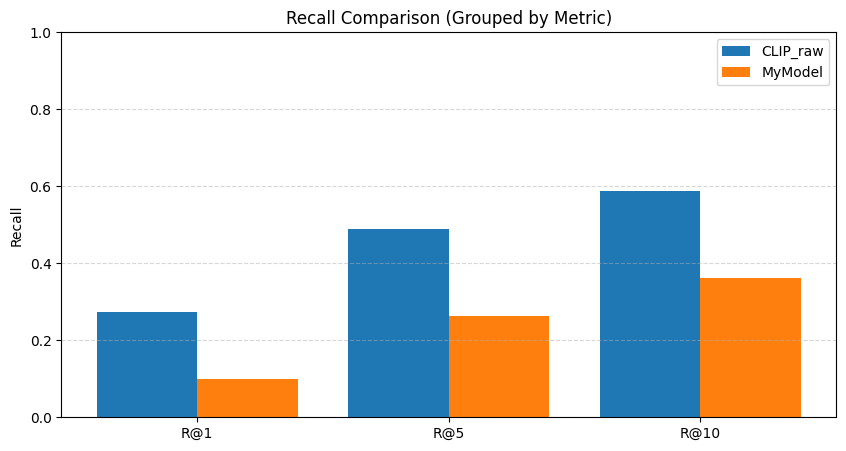

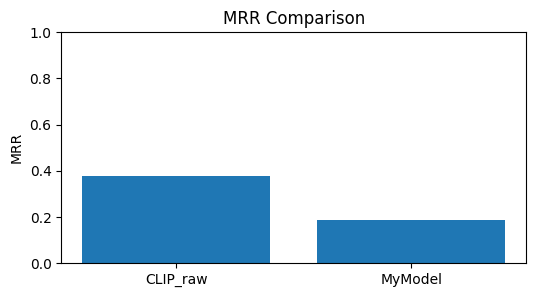

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---------- 1) helpers ----------
def to_numpy(x):
    if x is None:
        return None
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def normalize_rows(a):
    a = np.asarray(a).astype(np.float32)
    norm = np.linalg.norm(a, axis=1, keepdims=True)
    norm[norm==0] = 1.0
    return a / norm

def compute_retrieval_metrics(query_feats, db_feats, ground_truth_idx, topk=(1,5,10)):
    # query_feats: (N, D), db_feats: (M, D) numpy
    q = normalize_rows(query_feats)
    d = normalize_rows(db_feats)
    sims = q @ d.T
    ranks = (-sims).argsort(axis=1)
    N = sims.shape[0]
    recall = {k:0 for k in topk}
    mrr = 0.0
    for i in range(N):
        gt = int(ground_truth_idx[i])
        rank_of_gt = np.where(ranks[i] == gt)[0][0]  # 0-based
        for k in topk:
            if rank_of_gt < k:
                recall[k] += 1
        mrr += 1.0 / (rank_of_gt + 1)
    recall = {k: recall[k] / N for k in topk}
    mrr = mrr / N
    return recall, mrr

# ---------- 2) preparing for embeddings ----------
# raw_img_embeds, raw_txt_embeds  (N x D) needed
img_emb_raw = to_numpy(raw_img_embeds)   # CLIP raw image features
txt_emb_raw = to_numpy(raw_txt_embeds)   # CLIP raw text features
N = img_emb_raw.shape[0]
print("number of sampled data：", N)

# baseline A: CLIP raw (cosine similarity)
clip_img = normalize_rows(img_emb_raw)
clip_txt = normalize_rows(txt_emb_raw)

# ---------- 2b) my_model ----------
def compute_model_embs_from_model(model, img_feats, txt_feats, batch=1024, device=torch.device("cpu")):
    model_device = device
    model = model.to(model_device)
    model.eval()
    all_img_proj = []
    all_txt_proj = []
    with torch.no_grad():
        import math
        B = batch
        for i in range(0, img_feats.shape[0], B):
            ib = torch.from_numpy(img_feats[i:i+B]).float().to(model_device)
            tb = torch.from_numpy(txt_feats[i:i+B]).float().to(model_device)

            out_img, out_txt = model(ib, tb)
            # in case that tuple/list with extra, adapt as needed
            if isinstance(out_img, tuple) or isinstance(out_img, list):
                out_img = out_img[0]
            if isinstance(out_txt, tuple) or isinstance(out_txt, list):
                out_txt = out_txt[0]
            all_img_proj.append(out_img.detach().cpu().numpy())
            all_txt_proj.append(out_txt.detach().cpu().numpy())
    img_proj = np.vstack(all_img_proj)
    txt_proj = np.vstack(all_txt_proj)
    # normalize
    img_proj = normalize_rows(img_proj)
    txt_proj = normalize_rows(txt_proj)
    return img_proj, txt_proj

# make sure my_model is here
try:
    device_for_model = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    my_img_emb, my_txt_emb = compute_model_embs_from_model(my_model, img_emb_raw, txt_emb_raw, batch=512, device=device_for_model)
    print("Computed embeddings from my_model.")
except Exception as e:
    print("my_model error, no way to compute embedding：", e)
    my_img_emb, my_txt_emb = None, None

# ---------- 3) computing ----------
ground_truth = np.arange(N)

results = {}

# CLIP raw
rec_clip, mrr_clip = compute_retrieval_metrics(clip_txt, clip_img, ground_truth)
results['CLIP_raw'] = (rec_clip, mrr_clip)

# My model (if computed)
if my_img_emb is not None:
    rec_my, mrr_my = compute_retrieval_metrics(my_txt_emb, my_img_emb, ground_truth)
    results['MyModel'] = (rec_my, mrr_my)

# ---------- 4) print results table ----------
def print_results_table(results):
    ks = [1,5,10]
    header = ["Model", "R@1", "R@5", "R@10", "MRR"]
    print("{:<15} {:>6} {:>6} {:>6} {:>8}".format(*header))
    for k, v in results.items():
        rec, mrr = v
        print("{:<15} {:6.3f} {:6.3f} {:6.3f} {:8.3f}".format(k, rec[1], rec[5], rec[10], mrr))

print_results_table(results)

# ---------- 5) visualizition -- bar chart ----------
models = list(results.keys())     # e.g. ["CLIP_raw", "MyModel"]
num_models = len(models)

# performances on each model
vals = [ [results[m][0][1], results[m][0][5], results[m][0][10]] for m in models ]

vals = np.array(vals)  # shape: (num_models, 3)

x = np.arange(3)  # 0->R1, 1->R5, 2->R10
width = 0.8 / max(1, num_models)

plt.figure(figsize=(10,5))

for i, m in enumerate(models):
    plt.bar(x + (i - num_models/2)*width + width/2, vals[i],
            width=width, label=m)

plt.xticks(x, ["R@1", "R@5", "R@10"])
plt.ylim(0,1)
plt.ylabel("Recall")
plt.title("Recall Comparison (Grouped by Metric)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# ---------- MRR ----------
plt.figure(figsize=(6,3))
mrrs = [results[m][1] for m in models]
plt.bar(models, mrrs)
plt.ylim(0,1)
plt.title("MRR Comparison")
plt.ylabel("MRR")
plt.show()


We found that my_model did not do a good job as we imagine, so we keep trying

# **stageA_model**

At this time, we made residual projection heads, add logit scale and ues objective function --- InfoNCE Loss as our loss in the training loop

In [7]:
import copy, time, numpy as np, torch, os
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

# ---------- Helpers ----------
def to_numpy(x):
    if isinstance(x, np.ndarray): return x
    if torch.is_tensor(x): return x.detach().cpu().numpy()
    return np.array(x)

def to_tensor(x):
    if torch.is_tensor(x): return x
    return torch.tensor(x, dtype=torch.float32)

def normalize_rows(a):
    a = np.asarray(a, dtype=np.float32)
    n = np.linalg.norm(a, axis=1, keepdims=True)
    n[n==0] = 1.0
    return a / n

def compute_retrieval_metrics(query_feats, db_feats, ground_truth_idx, topk=(1,5,10)):
    q = normalize_rows(query_feats)
    d = normalize_rows(db_feats)
    sims = q @ d.T
    ranks = (-sims).argsort(axis=1)
    N = sims.shape[0]
    recall = {k:0 for k in topk}
    mrr = 0.0
    for i in range(N):
        gt = int(ground_truth_idx[i])
        pos = np.where(ranks[i] == gt)[0][0]
        for k in topk:
            if pos < k:
                recall[k] += 1
        mrr += 1.0/(pos+1)
    recall = {k: recall[k]/N for k in topk}
    mrr = mrr / N
    return recall, mrr

def compute_representations_from_heads(model, img_feats, txt_feats, batch=512, device=torch.device("cpu")):
    model = model.to(device)
    model.eval()
    all_img=[]; all_txt=[]
    with torch.no_grad():
        for i in range(0, img_feats.shape[0], batch):
            ib = torch.from_numpy(img_feats[i:i+batch]).float().to(device)
            tb = torch.from_numpy(txt_feats[i:i+batch]).float().to(device)
            if hasattr(model, "img_head") and hasattr(model, "txt_head"):
                im_p = model.img_head(ib)
                tx_p = model.txt_head(tb)
            else:
                im_p, tx_p = model(ib, tb)
            im_p = F.normalize(im_p, dim=1)
            tx_p = F.normalize(tx_p, dim=1)
            all_img.append(im_p.cpu().numpy()); all_txt.append(tx_p.cpu().numpy())
    return np.vstack(all_img), np.vstack(all_txt)

In [8]:
# ---------- ResidualProjectionHead ----------
class ResidualProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=1024, out_dim=512, dropout=0.05, alpha=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim)
        )
        if in_dim != out_dim:
            self.base_proj = nn.Linear(in_dim, out_dim, bias=False)
            with torch.no_grad():
                m = min(in_dim, out_dim)
                W = torch.zeros(out_dim, in_dim)
                W[:m, :m] = torch.eye(m)
                self.base_proj.weight.copy_(W)
        else:
            self.base_proj = None
        self.alpha = alpha
    def forward(self, x):
        head_out = self.net(x)
        x_proj = self.base_proj(x) if self.base_proj is not None else x
        return x_proj + self.alpha * head_out

In [9]:
# ---------- configure ----------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)
epochs_stageA = 10
batch_size = 128
grad_accum_steps = 2
lr_head = 1e-4
weight_decay = 1e-2
use_mixed_precision = True
max_grad_norm = 1.0
head_hidden = 1024
head_out = 512
head_dropout = 0.05
res_alpha = 0.2

Device: cuda


In [10]:
# ---------- checking ----------
assert ('raw_img_embeds' in globals() or 'raw_img_embeds' in locals()), "请先准备 raw_img_embeds"
assert ('raw_txt_embeds' in globals() or 'raw_txt_embeds' in locals()), "请先准备 raw_txt_embeds"
assert ('my_model' in globals() or 'my_model' in locals()), "请先准备 my_model 实例"

img_feats_all = to_numpy(raw_img_embeds)
txt_feats_all = to_numpy(raw_txt_embeds)
N = img_feats_all.shape[0]
print(f"Samples: {N}, img_in_dim={img_feats_all.shape[1]}, txt_in_dim={txt_feats_all.shape[1]}")

# dataloader
t_img = to_tensor(img_feats_all)
t_txt = to_tensor(txt_feats_all)
dataset = TensorDataset(t_img, t_txt)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# CLIP raw baseline
clip_img_emb = normalize_rows(img_feats_all)
clip_txt_emb = normalize_rows(txt_feats_all)

# Attempt to compute Original embeddings from my_model; fallback to CLIP raw on error
try:
    orig_img_emb, orig_txt_emb = compute_representations_from_heads(my_model, img_feats_all, txt_feats_all, batch=512, device=device)
    print("Original embeddings from my_model computed.")
except Exception as e:
    print("Failed to compute embeddings from my_model, falling back to CLIP raw. Error:", e)
    orig_img_emb, orig_txt_emb = clip_img_emb, clip_txt_emb

# prepare finetune model (deepcopy + replace heads)
finetune_model = copy.deepcopy(my_model).to(device)
if not hasattr(finetune_model, "logit_scale"):
    finetune_model.logit_scale = nn.Parameter(torch.tensor(np.log(1/0.07), dtype=torch.float32).to(device))

in_img_dim = img_feats_all.shape[1]
in_txt_dim = txt_feats_all.shape[1]
finetune_model.img_head = ResidualProjectionHead(in_img_dim, hidden_dim=head_hidden, out_dim=head_out, dropout=head_dropout, alpha=res_alpha).to(device)
finetune_model.txt_head = ResidualProjectionHead(in_txt_dim, hidden_dim=head_hidden, out_dim=head_out, dropout=head_dropout, alpha=res_alpha).to(device)

# Freeze backbone, unfreeze heads only
for p in finetune_model.parameters():
    p.requires_grad = False
for p in finetune_model.img_head.parameters():
    p.requires_grad = True
for p in finetune_model.txt_head.parameters():
    p.requires_grad = True
finetune_model.logit_scale.requires_grad = True

head_params = list(filter(lambda p: p.requires_grad, finetune_model.parameters()))
optimizer = AdamW(head_params, lr=lr_head, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=max(1, epochs_stageA))
scaler = GradScaler() if use_mixed_precision else None

def info_nce_heads(img_clip, txt_clip, model):
    img_proj = model.img_head(img_clip)
    txt_proj = model.txt_head(txt_clip)
    img_n = F.normalize(img_proj, dim=1)
    txt_n = F.normalize(txt_proj, dim=1)
    logits = img_n @ txt_n.t() * model.logit_scale.exp()
    labels = torch.arange(logits.size(0), device=logits.device)
    return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2

Samples: 19998, img_in_dim=512, txt_in_dim=512
Original embeddings from my_model computed.


/tmp/ipython-input-1232130479.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_mixed_precision else None


In [11]:
# ---------- Stage A training ----------
stageA_losses = []
print("=== Stage A training (heads only) ===")
finetune_model.train()
for epoch in range(epochs_stageA):
    t0 = time.time()
    running = 0.0
    n_steps = 0
    optimizer.zero_grad()
    for step, batch in enumerate(train_loader):
        img_b = batch[0].to(device).float()
        txt_b = batch[1].to(device).float()
        if use_mixed_precision:
            with autocast():
                loss = info_nce_heads(img_b, txt_b, finetune_model) / grad_accum_steps
            scaler.scale(loss).backward()
        else:
            loss = info_nce_heads(img_b, txt_b, finetune_model) / grad_accum_steps
            loss.backward()
        if (step + 1) % grad_accum_steps == 0:
            if use_mixed_precision:
                scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, finetune_model.parameters()), max_grad_norm)
            if use_mixed_precision:
                scaler.step(optimizer); scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            n_steps += 1
        running += float((loss * grad_accum_steps).detach().cpu().item())
    avg_loss = running / (n_steps if n_steps>0 else 1)
    stageA_losses.append(avg_loss)
    scheduler.step()
    print(f"StageA Epoch {epoch+1}/{epochs_stageA} avg_loss={avg_loss:.4f} time={time.time()-t0:.1f}s")

# save stageA checkpoint
ckptA = {"model_state_dict": finetune_model.state_dict(), "head_out_dim": head_out,
         "meta": {"epochs_stageA": epochs_stageA, "head_hidden": head_hidden, "head_out": head_out}}
torch.save(ckptA, "finetune_stageA_only.pth")
print("Saved finetune_stageA_only.pth")

=== Stage A training (heads only) ===


/tmp/ipython-input-1409078319.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


StageA Epoch 1/10 avg_loss=4.5032 time=1.1s
StageA Epoch 2/10 avg_loss=2.2724 time=0.8s
StageA Epoch 3/10 avg_loss=1.7373 time=0.8s
StageA Epoch 4/10 avg_loss=1.4625 time=0.8s
StageA Epoch 5/10 avg_loss=1.2889 time=0.8s
StageA Epoch 6/10 avg_loss=1.1723 time=0.8s
StageA Epoch 7/10 avg_loss=1.1016 time=0.8s
StageA Epoch 8/10 avg_loss=1.0417 time=0.8s
StageA Epoch 9/10 avg_loss=1.0045 time=0.8s
StageA Epoch 10/10 avg_loss=1.0036 time=0.8s
Saved finetune_stageA_only.pth


In [12]:
# ---------- Evaluation: compute embeddings & metrics (CLIP raw / Original / StageA) ----------
print("Computing embeddings for evaluation...")

def load_ckpt_into_model(ckpt_path, base_model, img_in_dim, txt_in_dim, device=torch.device('cpu')):
    model = copy.deepcopy(base_model)
    model.img_head = ResidualProjectionHead(img_in_dim, hidden_dim=head_hidden, out_dim=head_out, dropout=head_dropout, alpha=res_alpha).to(device)
    model.txt_head = ResidualProjectionHead(txt_in_dim, hidden_dim=head_hidden, out_dim=head_out, dropout=head_dropout, alpha=res_alpha).to(device)
    if not hasattr(model, "logit_scale"):
        model.logit_scale = nn.Parameter(torch.tensor(np.log(1/0.07), dtype=torch.float32).to(device))
    sd = torch.load(ckpt_path, map_location='cpu')
    if isinstance(sd, dict) and "model_state_dict" in sd:
        sd = sd["model_state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print(f"Loaded {ckpt_path} missing_keys:{len(missing)} unexpected_keys:{len(unexpected)}")
    return model

stageA_model = load_ckpt_into_model("finetune_stageA_only.pth", my_model, in_img_dim, in_txt_dim, device=device)

stageA_img_emb, stageA_txt_emb = compute_representations_from_heads(stageA_model, img_feats_all, txt_feats_all, batch=512, device=device)
orig_img_emb2, orig_txt_emb2 = orig_img_emb, orig_txt_emb
clip_img_emb2, clip_txt_emb2 = clip_img_emb, clip_txt_emb

# pad to max dim if mismatch
def pad_to_max_dim(a, b):
    a = np.asarray(a); b = np.asarray(b)
    maxd = max(a.shape[1], b.shape[1])
    if a.shape[1] < maxd:
        a = np.concatenate([a, np.zeros((a.shape[0], maxd-a.shape[1]), dtype=a.dtype)], axis=1)
    if b.shape[1] < maxd:
        b = np.concatenate([b, np.zeros((b.shape[0], maxd-b.shape[1]), dtype=b.dtype)], axis=1)
    return a, b

orig_txt_emb2, orig_img_emb2       = pad_to_max_dim(orig_txt_emb2, orig_img_emb2)
stageA_txt_emb, stageA_img_emb     = pad_to_max_dim(stageA_txt_emb, stageA_img_emb)
clip_txt_emb2, clip_img_emb2       = pad_to_max_dim(clip_txt_emb2, clip_img_emb2)

gt = np.arange(N)
rec_clip, mrr_clip = compute_retrieval_metrics(clip_txt_emb2, clip_img_emb2, gt)
rec_orig, mrr_orig = compute_retrieval_metrics(orig_txt_emb2, orig_img_emb2, gt)
rec_A, mrr_A       = compute_retrieval_metrics(stageA_txt_emb, stageA_img_emb, gt)

print("\n=== Metrics ===")
print("CLIP raw ->", rec_clip, "MRR", mrr_clip)
print("Original ->", rec_orig, "MRR", mrr_orig)
print("StageA ->", rec_A, "MRR", mrr_A)

Computing embeddings for evaluation...
Loaded finetune_stageA_only.pth missing_keys:0 unexpected_keys:0

=== Metrics ===
CLIP raw -> {1: 0.2728772877287729, 5: 0.48999899989999, 10: 0.5873087308730873} MRR 0.3780306020663063
Original -> {1: 0.09960996099609962, 5: 0.26227622762276226, 10: 0.3625362536253625} MRR 0.1862655980046539
StageA -> {1: 0.2893289328932893, 5: 0.5735573557355735, 10: 0.6973197319731973} MRR 0.4224099149184093


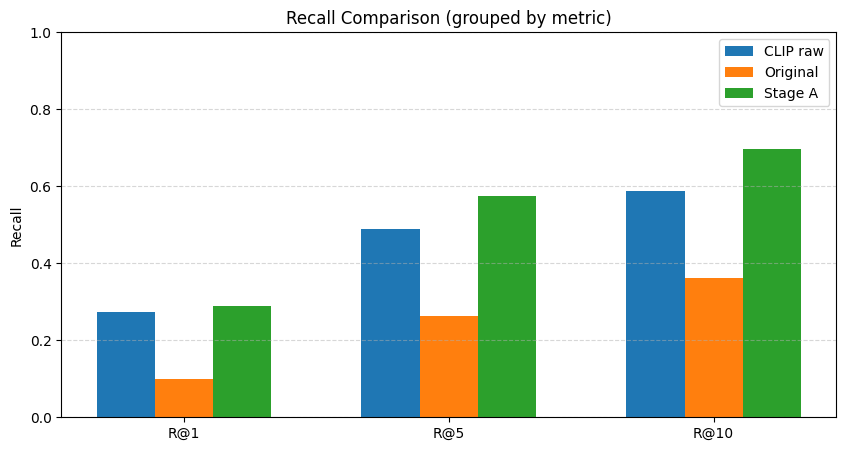

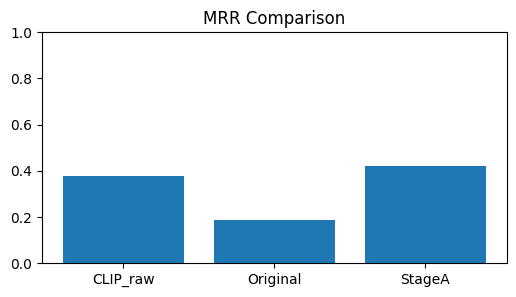

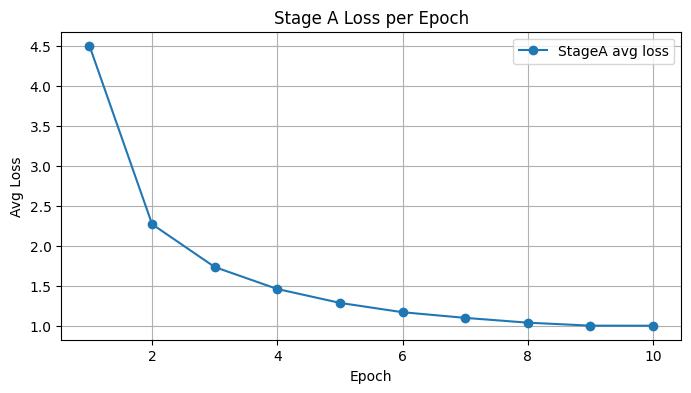

Done. Checkpoint: finetune_stageA_only.pth


In [13]:
# ---------- Plots: Recall / MRR / Loss ----------
models = ["CLIP_raw", "Original", "StageA"]
vals = {
    "CLIP_raw":[rec_clip[1], rec_clip[5], rec_clip[10]],
    "Original":[rec_orig[1], rec_orig[5], rec_orig[10]],
    "StageA":[rec_A[1], rec_A[5], rec_A[10]],
}
x = np.arange(3)
width = 0.22
plt.figure(figsize=(10,5))
plt.bar(x - width, vals["CLIP_raw"], width, label='CLIP raw')
plt.bar(x, vals["Original"], width, label='Original')
plt.bar(x + width, vals["StageA"], width, label='Stage A')
plt.xticks(x, ['R@1', 'R@5', 'R@10'])
plt.ylim(0,1); plt.ylabel('Recall')
plt.title('Recall Comparison (grouped by metric)')
plt.legend(); plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(6,3))
plt.bar(models, [mrr_clip, mrr_orig, mrr_A])
plt.ylim(0,1); plt.title("MRR Comparison"); plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(stageA_losses)+1), stageA_losses, marker='o', label='StageA avg loss')
plt.xlabel("Epoch"); plt.ylabel("Avg Loss")
plt.title("Stage A Loss per Epoch"); plt.legend(); plt.grid(True); plt.show()

print("Done. Checkpoint: finetune_stageA_only.pth")

# **Evaluation**

Instead of relying only on recall and MRR, we also want to directly inspect how well our model retrieves relevant images. Therefore, we implemented a function that retrieves the top-k most appropriate images from our dataset for any given text query.

In [14]:
from transformers import CLIPProcessor, CLIPModel
import torch

clip_model_name = "openai/clip-vit-base-patch32"

print(f"Loading CLIP model: {clip_model_name} ...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for CLIP:", device)

# download processor + model
processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)

clip_model.eval()

print("CLIP model & processor loaded.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading CLIP model: openai/clip-vit-base-patch32 ...
Device for CLIP: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CLIP model & processor loaded.


In [15]:
def retrieve_topk_compare_all_with_labels(
    query_text,
    top_k=10,
    image_folder=None,
    thumb_height=140,
    show_plot=True,
    rebuild_cache=False,
    ckpt_path="finetune_stageA_only.pth",
    batch=512,
    device_override=None
):
    """
    同时返回 raw CLIP / my_model / stageA 三种 top-k，并把每张图下面画上相应的文本（截断或换行显示）。
    使用方式与之前的 retrieve_topk_compare_all 类似；本函数重点在可视化（显示文本）。
    """
    import os, textwrap, numpy as np, pandas as pd
    import torch, torch.nn.functional as F
    from PIL import Image
    import matplotlib.pyplot as plt

    dev = torch.device(device_override) if device_override is not None else (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    print("Using device:", dev)

    # basic checks
    if 'clip_model' not in globals() or 'processor' not in globals():
        raise RuntimeError("请先加载全局 clip_model 和 processor")
    if 'img_feats_all' not in globals() or 'txt_feats_all' not in globals():
        raise RuntimeError("请先准备全局 img_feats_all, txt_feats_all（原始 embeddings）")
    if 'my_model' not in globals():
        raise RuntimeError("请先准备全局 my_model")

    img_feats = np.asarray(img_feats_all, dtype=np.float32)
    N = img_feats.shape[0]

    def _norm_rows(a):
        a = np.asarray(a, dtype=np.float32)
        n = np.linalg.norm(a, axis=1, keepdims=True)
        n[n==0] = 1.0
        return a / n

    # CLIP raw image emb
    clip_img_emb = _norm_rows(img_feats)

    # compute/cached my_model image emb
    def _compute_my_img_emb():
        model = my_model.to(dev); model.eval()
        parts = []
        with torch.no_grad():
            for i in range(0, N, batch):
                ib = torch.from_numpy(img_feats[i:i+batch]).float().to(dev)
                if hasattr(model, "img_head"):
                    out = model.img_head(ib)
                elif hasattr(model, "encode_image"):
                    out = model.encode_image(ib)
                else:
                    out, _ = model(ib, ib)
                parts.append(F.normalize(out, dim=1).cpu().numpy())
        arr = np.vstack(parts).astype(np.float32)
        globals()['my_img_emb'] = arr
        globals()['_my_img_cache_meta'] = {'n': arr.shape[0], 'dim': arr.shape[1]}
        return arr

    need_my = rebuild_cache or ('my_img_emb' not in globals())
    if not need_my and '_my_img_cache_meta' in globals():
        md = globals()['_my_img_cache_meta']
        if md.get('n') != N:
            need_my = True
    my_img_emb = _compute_my_img_emb() if need_my else np.asarray(globals()['my_img_emb'], dtype=np.float32)
    my_img_emb = _norm_rows(my_img_emb)
    globals()['my_img_emb'] = my_img_emb

    # stageA (optional)
    stageA_img_emb = None
    stageA_model_local = None
    if 'stageA_model' in globals() and not rebuild_cache:
        stageA_model_local = globals()['stageA_model']
    else:
        if os.path.exists(ckpt_path):
            try:
                stageA_model_local = load_ckpt_into_model(ckpt_path, my_model, img_feats.shape[1], txt_feats_all.shape[1], device=dev)
                globals()['stageA_model'] = stageA_model_local
            except Exception as e:
                print("Warning: could not load stageA_model:", e)
                stageA_model_local = None
    if stageA_model_local is not None:
        def _compute_stageA_img_emb():
            model = stageA_model_local; model.eval()
            parts = []
            with torch.no_grad():
                for i in range(0, N, batch):
                    ib = torch.from_numpy(img_feats[i:i+batch]).float().to(dev)
                    if hasattr(model, "img_head"):
                        out = model.img_head(ib)
                    elif hasattr(model, "encode_image"):
                        out = model.encode_image(ib)
                    else:
                        out, _ = model(ib, ib)
                    parts.append(F.normalize(out, dim=1).cpu().numpy())
            arr = np.vstack(parts).astype(np.float32)
            globals()['stageA_img_emb'] = arr
            globals()['_stageA_img_cache_meta'] = {'n': arr.shape[0], 'dim': arr.shape[1]}
            return arr
        need_stage = rebuild_cache or ('stageA_img_emb' not in globals())
        if not need_stage and '_stageA_img_cache_meta' in globals():
            md = globals()['_stageA_img_cache_meta']
            if md.get('n') != N:
                need_stage = True
        stageA_img_emb = _compute_stageA_img_emb() if need_stage else np.asarray(globals()['stageA_img_emb'], dtype=np.float32)
        stageA_img_emb = _norm_rows(stageA_img_emb)

    # encode query raw CLIP
    inputs = processor(text=[query_text], return_tensors="pt", truncation=True, padding=True).to(dev)
    with torch.no_grad():
        raw_txt = clip_model.get_text_features(**inputs)
    raw_txt_n = F.normalize(raw_txt, dim=1).cpu().numpy().astype(np.float32)

    # project raw txt by my_model
    model = my_model.to(dev); model.eval()
    with torch.no_grad():
        tb = raw_txt.float().to(dev)
        if hasattr(model, "txt_head"):
            my_txt_proj_t = model.txt_head(tb)
        elif hasattr(model, "encode_text"):
            my_txt_proj_t = model.encode_text(tb)
        else:
            _, my_txt_proj_t = model(torch.zeros(1, img_feats.shape[1], device=dev), tb)
        my_txt_proj_t = F.normalize(my_txt_proj_t, dim=1).cpu().numpy().astype(np.float32)

    # stageA txt proj if available
    stageA_txt_proj = None
    if stageA_model_local is not None:
        with torch.no_grad():
            tb2 = raw_txt.float().to(dev)
            if hasattr(stageA_model_local, "txt_head"):
                stageA_txt_proj_t = stageA_model_local.txt_head(tb2)
            elif hasattr(stageA_model_local, "encode_text"):
                stageA_txt_proj_t = stageA_model_local.encode_text(tb2)
            else:
                _, stageA_txt_proj_t = stageA_model_local(torch.zeros(1, img_feats.shape[1], device=dev), tb2)
            stageA_txt_proj = F.normalize(stageA_txt_proj_t, dim=1).cpu().numpy().astype(np.float32)

    # topk helper
    def _topk(qvec, db_emb, k):
        if db_emb is None: return None, None
        sims = (qvec @ db_emb.T).ravel().astype(np.float32)
        n = sims.shape[0]
        if n == 0: return np.array([], dtype=int), np.array([], dtype=float)
        kk = min(int(k), n)
        if kk < n:
            part = np.argpartition(-sims, kk-1)[:kk]
            order = part[np.argsort(-sims[part])]
        else:
            order = np.argsort(-sims)[::-1]
        return order, sims[order]

    k = min(top_k, N)
    clip_order, clip_scores = _topk(raw_txt_n, clip_img_emb, k)
    my_order, my_scores = _topk(my_txt_proj_t, my_img_emb, k)
    stageA_order, stageA_scores = (None, None)
    if stageA_txt_proj is not None:
        stageA_order, stageA_scores = _topk(stageA_txt_proj, stageA_img_emb, k)

    # gather texts & img_paths robustly
    has_proc = ('proc_df' in globals()) and isinstance(proc_df, pd.DataFrame)
    proc_len = len(proc_df) if has_proc else 0
    use_iloc = False
    if has_proc:
        idx_range = isinstance(proc_df.index, pd.RangeIndex) and proc_df.index.start == 0 and proc_df.index.stop == proc_len
        use_iloc = idx_range

    def _gather(order):
        texts=[]; paths=[]
        if order is None: return texts, paths
        for idx in order:
            t = "<no text>"
            if has_proc:
                try:
                    if use_iloc and int(idx) < proc_len:
                        rawv = proc_df.iloc[int(idx)].get('text', None) if 'text' in proc_df.columns else None
                    else:
                        if int(idx) in proc_df.index:
                            rawv = proc_df.loc[int(idx)].get('text', None) if 'text' in proc_df.columns else None
                        elif int(idx) < proc_len:
                            rawv = proc_df.iloc[int(idx)].get('text', None) if 'text' in proc_df.columns else None
                        else:
                            rawv = None
                    if pd.notna(rawv):
                        t = str(rawv)
                except Exception:
                    t = "<no text>"
            texts.append(t)

            # image path
            path = None
            if has_proc and 'image_path' in proc_df.columns:
                try:
                    if use_iloc and int(idx) < proc_len:
                        cand = proc_df.iloc[int(idx)]['image_path']
                    else:
                        if int(idx) in proc_df.index:
                            cand = proc_df.loc[int(idx)]['image_path']
                        elif int(idx) < proc_len:
                            cand = proc_df.iloc[int(idx)]['image_path']
                        else:
                            cand = None
                    if pd.notna(cand) and isinstance(cand, str) and cand.strip() != "":
                        path = cand
                except Exception:
                    path = None
            if path is None and image_folder is not None:
                cand_j = os.path.join(image_folder, f"{int(idx)}.jpg")
                cand_p = os.path.join(image_folder, f"{int(idx)}.png")
                if os.path.exists(cand_j):
                    path = cand_j
                elif os.path.exists(cand_p):
                    path = cand_p
            paths.append(path)
        return texts, paths

    clip_texts, clip_paths = _gather(clip_order)
    my_texts, my_paths = _gather(my_order)
    stageA_texts, stageA_paths = _gather(stageA_order) if stageA_order is not None else (None, None)

    # ---------------- Visualization: stacked rows, display text under each image ----------------
    if show_plot:
        rows_data = [
            ("CLIP raw", clip_order, clip_scores, clip_texts, clip_paths),
            ("my_model", my_order, my_scores, my_texts, my_paths),
            ("stageA", stageA_order, stageA_scores, stageA_texts, stageA_paths),
        ]
        rows_data = [r for r in rows_data if r[1] is not None]
        num_rows = len(rows_data)
        max_k = min(top_k, 12)     # cap columns
        fig_h = num_rows * 3.6
        fig_w = max_k * 2.8
        fig, axes = plt.subplots(num_rows, max_k, figsize=(fig_w, fig_h))
        if num_rows == 1:
            axes = np.expand_dims(axes, axis=0)
        if max_k == 1:
            axes = np.expand_dims(axes, axis=1)

        for r_idx, (title, order_arr, scores_arr, texts_arr, paths_arr) in enumerate(rows_data):
            # model title on leftmost subplot
            for c_idx in range(max_k):
                ax = axes[r_idx, c_idx]
                ax.axis('off')
                if c_idx >= len(order_arr):
                    continue
                idx = int(order_arr[c_idx])
                score = float(scores_arr[c_idx]) if scores_arr is not None else None
                txt = texts_arr[c_idx] if texts_arr and c_idx < len(texts_arr) else ""
                path = paths_arr[c_idx] if paths_arr and c_idx < len(paths_arr) else None

                # show image if exists, else placeholder text
                if path is not None and os.path.exists(path):
                    try:
                        im = Image.open(path).convert("RGB")
                        w,h = im.size
                        new_h = thumb_height
                        new_w = max(1, int(w * (new_h / float(h))))
                        im = im.resize((new_w, new_h), Image.LANCZOS)
                        ax.imshow(im)
                    except Exception:
                        ax.text(0.5,0.5,"image\nerror",ha='center',va='center')
                else:
                    ax.text(0.5,0.5,"no\nimage",ha='center',va='center')

                # model title (only once per row)
                if c_idx == 0:
                    ax.set_title(f"{title}", fontsize=12, loc='left')

                # caption: idx & score
                cap = f"idx={idx}"
                if score is not None:
                    cap += f" | {score:.3f}"
                # text: wrap to multiple lines (max 3 lines)
                wrapped = textwrap.fill(txt.replace("\n", " "), width=40)
                # limit to 3 lines
                wrapped_lines = wrapped.splitlines()[:3]
                wrapped = "\n".join(wrapped_lines)
                # place caption under image area
                ax.set_xlabel(cap + "\n" + wrapped, fontsize=8)
        plt.tight_layout()
        plt.show()

    out = {
        "clip_raw": (clip_order, clip_scores, clip_texts, clip_paths),
        "my_model": (my_order, my_scores, my_texts, my_paths),
        "stageA": (stageA_order, stageA_scores, stageA_texts, stageA_paths) if stageA_order is not None else None
    }
    return out


Using device: cuda


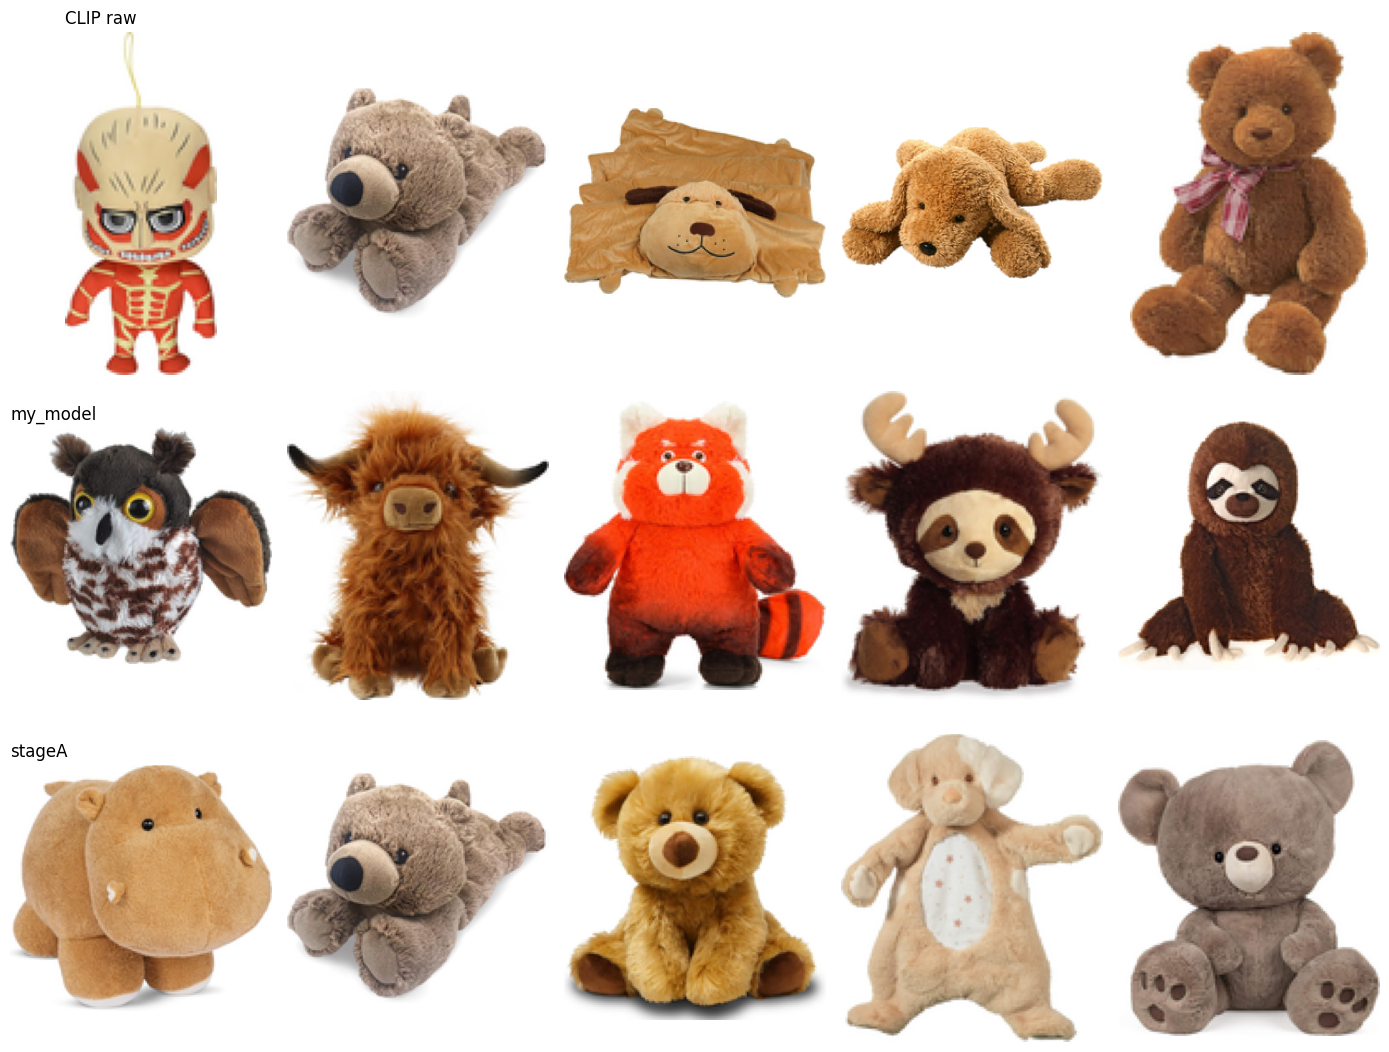

{'clip_raw': (array([19682, 15653, 10286, 14297,  9390]), array([0.31891122, 0.3153304 , 0.31527048, 0.3140293 , 0.31262052],
      dtype=float32), ['Great Eastern Attack on Titan Colossal Titan 8.5" Plush [\'Officially Licensed by Great Eastern\'\n \'New and sealed inside retail packaging\' \'Limited Availability\'\n \'Makes a Great Gift!\' \'Approx. Size: 5"L x 3"W x 8.5"H\'] ["Titans are the primary antagonists in the Attack on Titan series. They are a mysterious race of humanoid giants that appeared roughly 100 years ago (107 years is the most specific number given during Eren Yeager\'s training) and rapidly exterminated humanity to the point of near-extinction. If put into a calculable perspective, the Titans first appeared between Years 728 and 743. Their origins, overall numbers, and their physiological workings remain a mystery at this point in the story."] [\'Toys & Games\' \'Stuffed Animals & Plush Toys\' \'Plush Figures\'] {"Product Dimensions": "5 x 3 x 8.5 inches", "Item W

In [16]:
res = retrieve_topk_compare_all_with_labels("brown stuffed bear", top_k=5, image_folder="/path/to/images")
print(res)

Using device: cuda


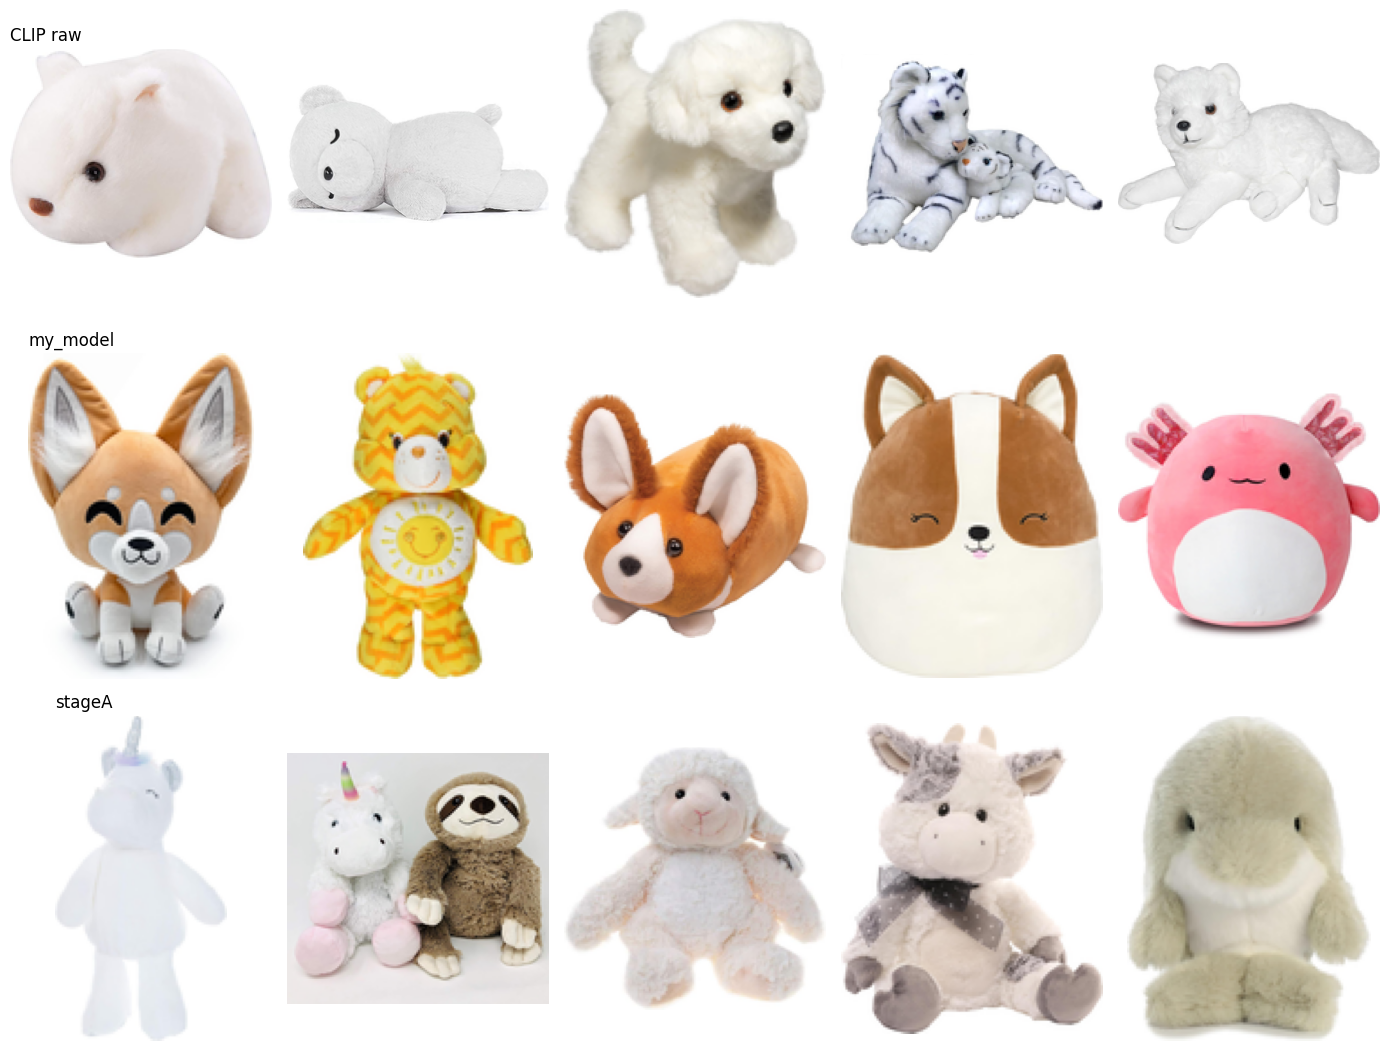

{'clip_raw': (array([ 5963,  8958,   715,  9579, 16739]), array([0.32785162, 0.32346612, 0.32186764, 0.32150573, 0.32131135],
      dtype=float32), ['Ashymily 7" Cute Plush Guinea Pig Toy Stuffed Guinea Pig Toys for Children, White [\'SIZE: Product measures 4 x 10 in inches | 10 x 18 in centimeters\'\n \'The fake fur is soft and not shedding, and with Average stuffing.\'\n \'This plush stuffed Chippy the hamster "Chipmunk" animal toy is securely sewn from the highest quality fabrics and filled with white plush filling.\'\n \'Washing Instructions: Please hand wash with light soap and cold water\'\n \'Recommended for ages 3+\'] ["Huggable Realistic Stuffed Animal Toy About our product: Exquisite workmanship makes the toy more realistic It\'s adorable and huggable It\'s actually looks like a guinea pig Great Gift Choice: It\'s a Christmas present for animal loving children and Easter baskets."] [\'Toys & Games\' \'Preschool\' \'Pre-Kindergarten Toys\'\n \'Stuffed Animals & Toys\'] {"Packa

In [17]:
res = retrieve_topk_compare_all_with_labels("white stuffed animal", top_k=5, image_folder="/path/to/images")
print(res)

Using device: cuda


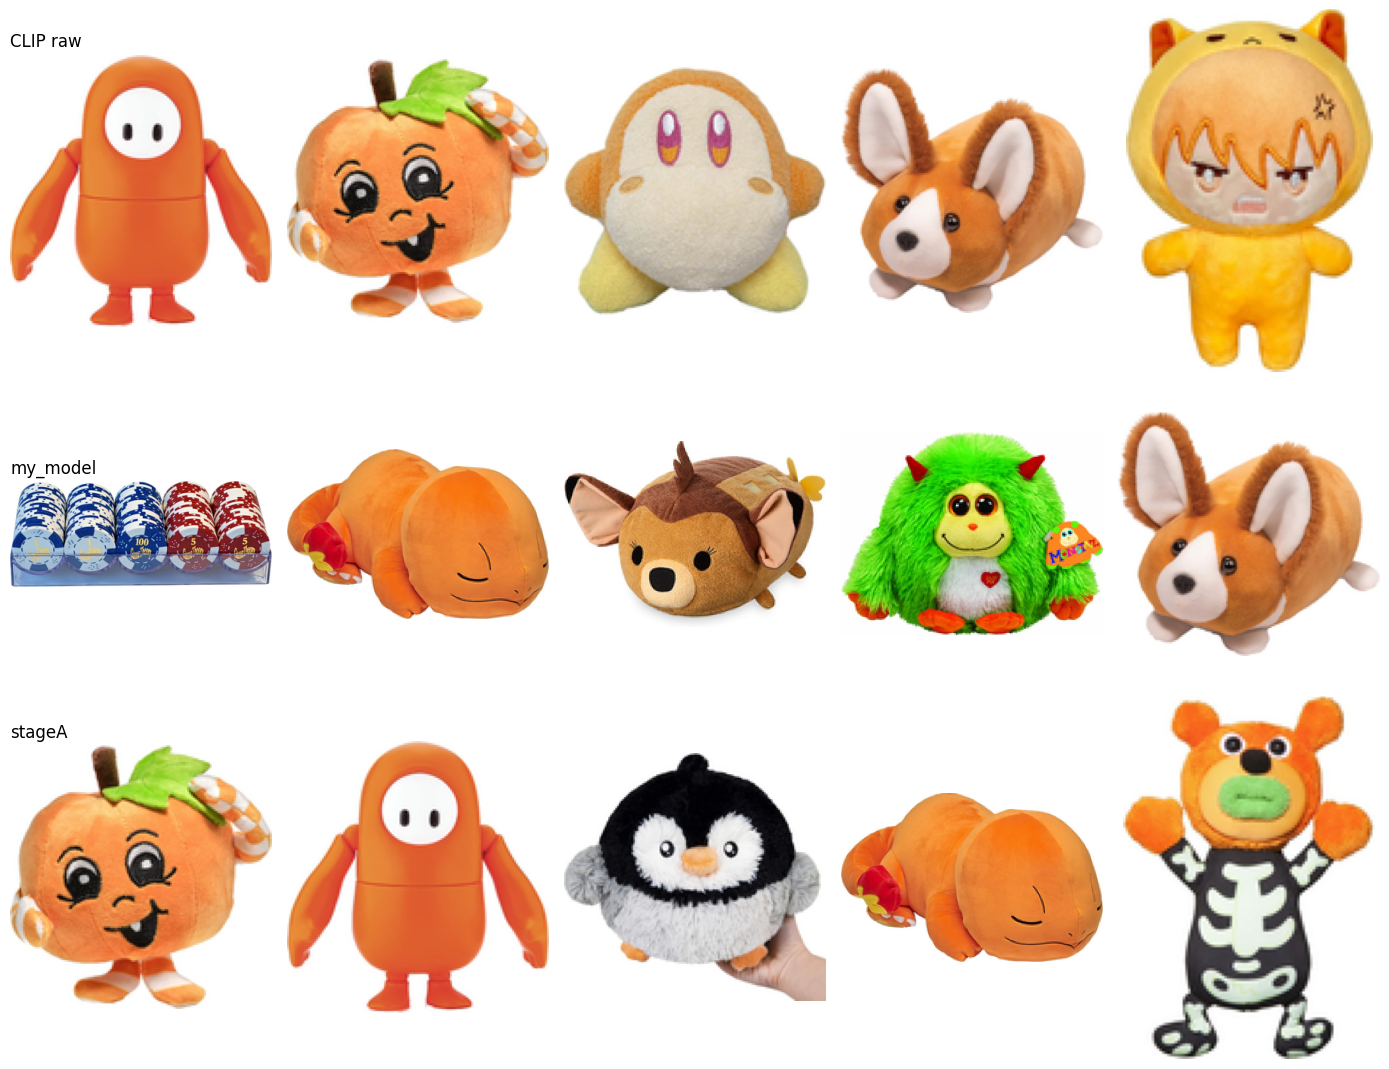

{'clip_raw': (array([15920,  3100,  4148, 13951,  4763]), array([0.33446229, 0.3326192 , 0.3306105 , 0.329197  , 0.32785758],
      dtype=float32), ['Kotobukiya Fall Guys: Movie Star and Chicken Costume Action Figure Pack 01 [\'A Kotobukiya Japanese import\'\n \'Three color face parts included plus Hearts and Lightning stickers\'\n \'Interchangeable upper and lower body parts to customize costume\'\n \'Includes a stand, props, and a crown\'\n \'Compatible with other figure packs in the series\'] [\'From Kotobukiya. The Fall Guys Collectible Pack 01 features the Movie Star starter color and the iconic Chicken Costume from Season 1. The Fall Guys can wear the costumes by simply putting them over their upper body parts and replacing their lower body parts, and the arms can be interchanged to recreate a range of poses! Not only that, there are three colors of face parts plus Hearts and Lightning stickers. The Fall Guys in this pack are compatible with others in the series, so you can custo

In [18]:
res = retrieve_topk_compare_all_with_labels("a small orange plush toy with big eyes", top_k=5, image_folder="/path/to/images")
print(res)

Using device: cuda


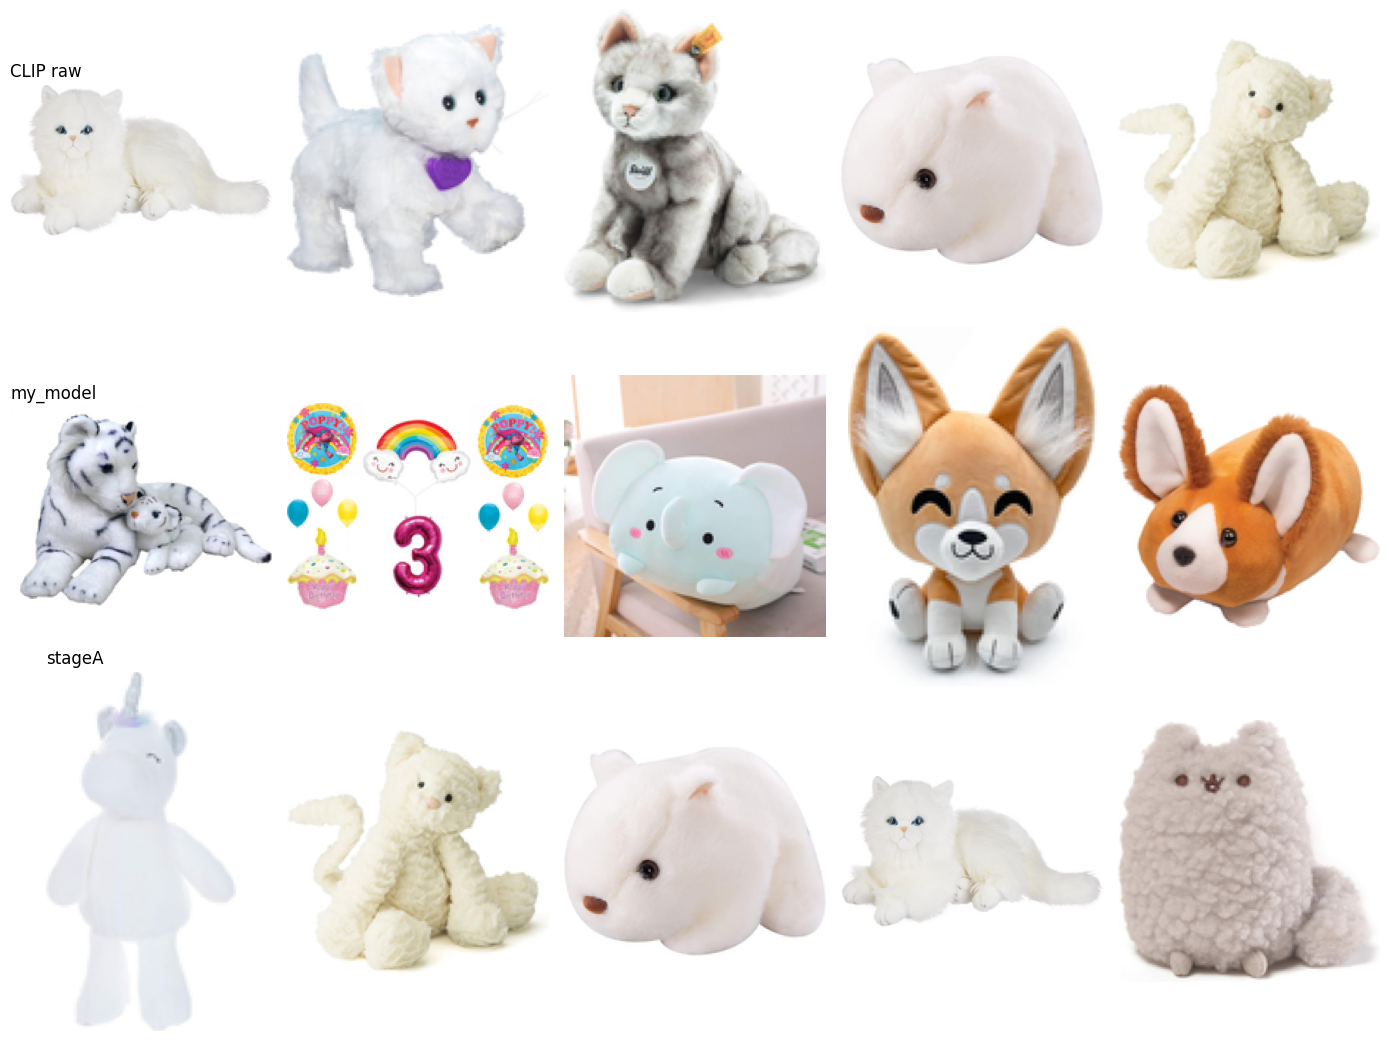

{'clip_raw': (array([12866,  6074, 14729,  5963,  2063]), array([0.38064206, 0.35352027, 0.34310904, 0.33901235, 0.33479303],
      dtype=float32), ['Ganz The Heritage Collection Kids Baby Plush Toy 12 inches - White Persian Cat [\'Brand Name: Ganz\'\n \'H14372 The Heritage Collection White Persian Cat, Plush Figures\'\n \'Plush toy\' \'Color: White\' \'Size: 12 inches length\'] ["Ganz is established by Samuel Ganz and sons Jack and Sam in 1950, this privately-held family company is now headed by the founder\'s grandson, Howard Ganz. Corporate headquarters are located in Woodbridge, ON, Canada. We deliver some of the best gifts in the world - giftware, fashion accessories, top-trending décor, baby fashion and huggable plush, garden, holiday and finishing touches for the home. Kissing Krystals and Crystal Expressions are some of the lines that make up our extensive family of products."] [\'Toys & Games\' \'Stuffed Animals & Plush Toys\' \'Plush Figures\'] {"Product Dimensions": "2 x 2 x

In [19]:
res = retrieve_topk_compare_all_with_labels("Ganz The Heritage Collection Kids Baby Plush Toy 12 inches - White Persian Cat ['Brand Name: Ganz' 'H14372 The Heritage Collection White Persian Cat, Plush Figures''Plush toy' 'Color: White'", top_k=5, image_folder="/path/to/images")
print(res)